## Load data

In [40]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
random_state = 12041500

In [41]:
df_train = pd.read_json("./data/synthetic_data_CTGANSynthesizer.json")
_df_train = pd.read_json("./data/synthetic_data_CTGANSynthesizer.json")
df_test = pd.read_json("./data/testset.json")

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
target = 'income'

df_train.drop(columns=["fnlwgt"], inplace=True)
_df_train.drop(columns=["fnlwgt"], inplace=True)
df_test.drop(columns=["fnlwgt"], inplace=True)

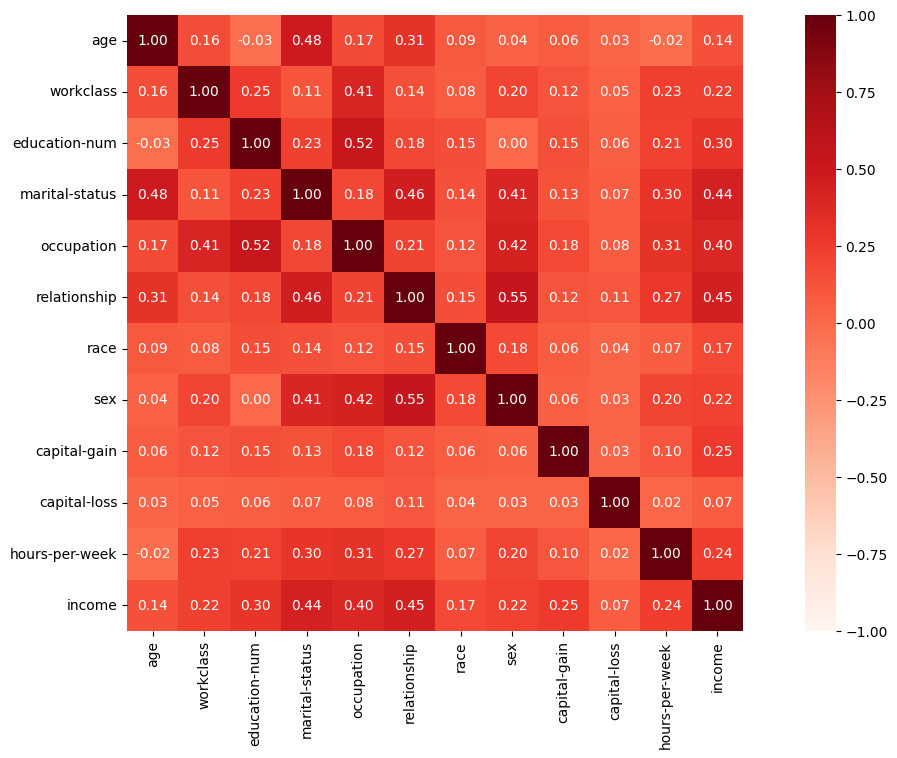

In [42]:
from dython.nominal import associations
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train, ax = ax, cmap = "Reds")

### Introduce (additional) sampling bias

In [43]:
from sklearn.utils import resample

data_less_equal_50k_Husband = df_train[df_train['income'] == 0 & (df_train['relationship'] == 'Husband')]
data_greater_50k_Husband = df_train[df_train['income'] == 1 & (df_train['relationship'] == 'Husband')]
data_unequal_Husbad = df_train[(df_train['relationship'] != 'Husband')]

data_less_equal_50k_Husband_undersampled = resample(data_less_equal_50k_Husband, replace=False, n_samples=int(len(data_less_equal_50k_Husband)*0.25), random_state=random_state)

biased_data = pd.concat([data_unequal_Husbad, data_greater_50k_Husband, data_less_equal_50k_Husband_undersampled])

df_train = biased_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
df_train.drop_duplicates(inplace=True)

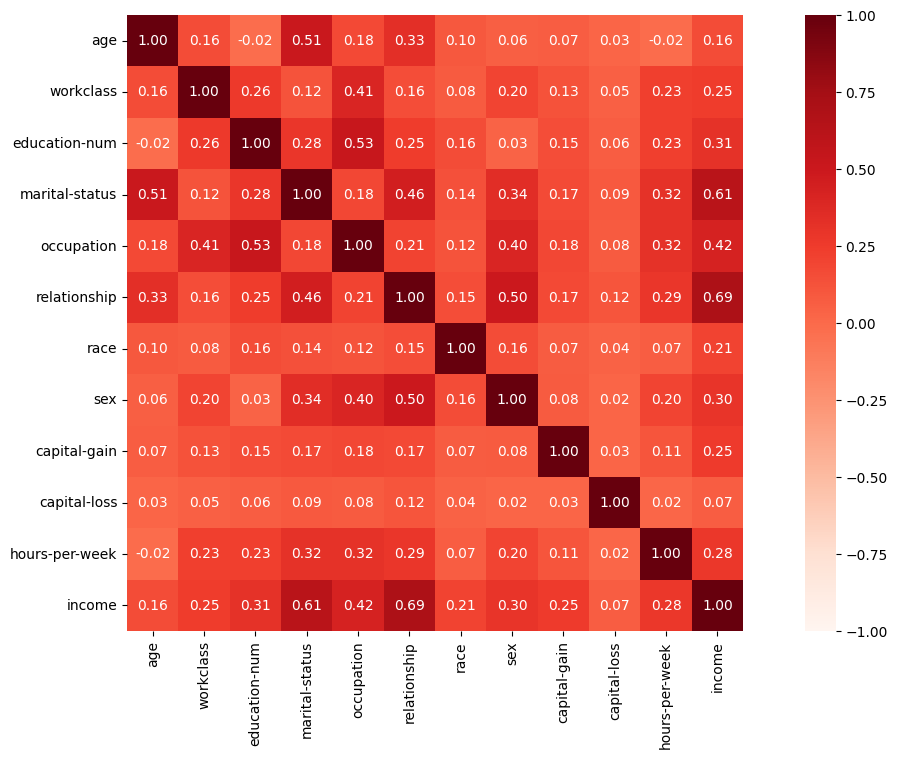

In [44]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train, ax = ax, cmap = "Reds")

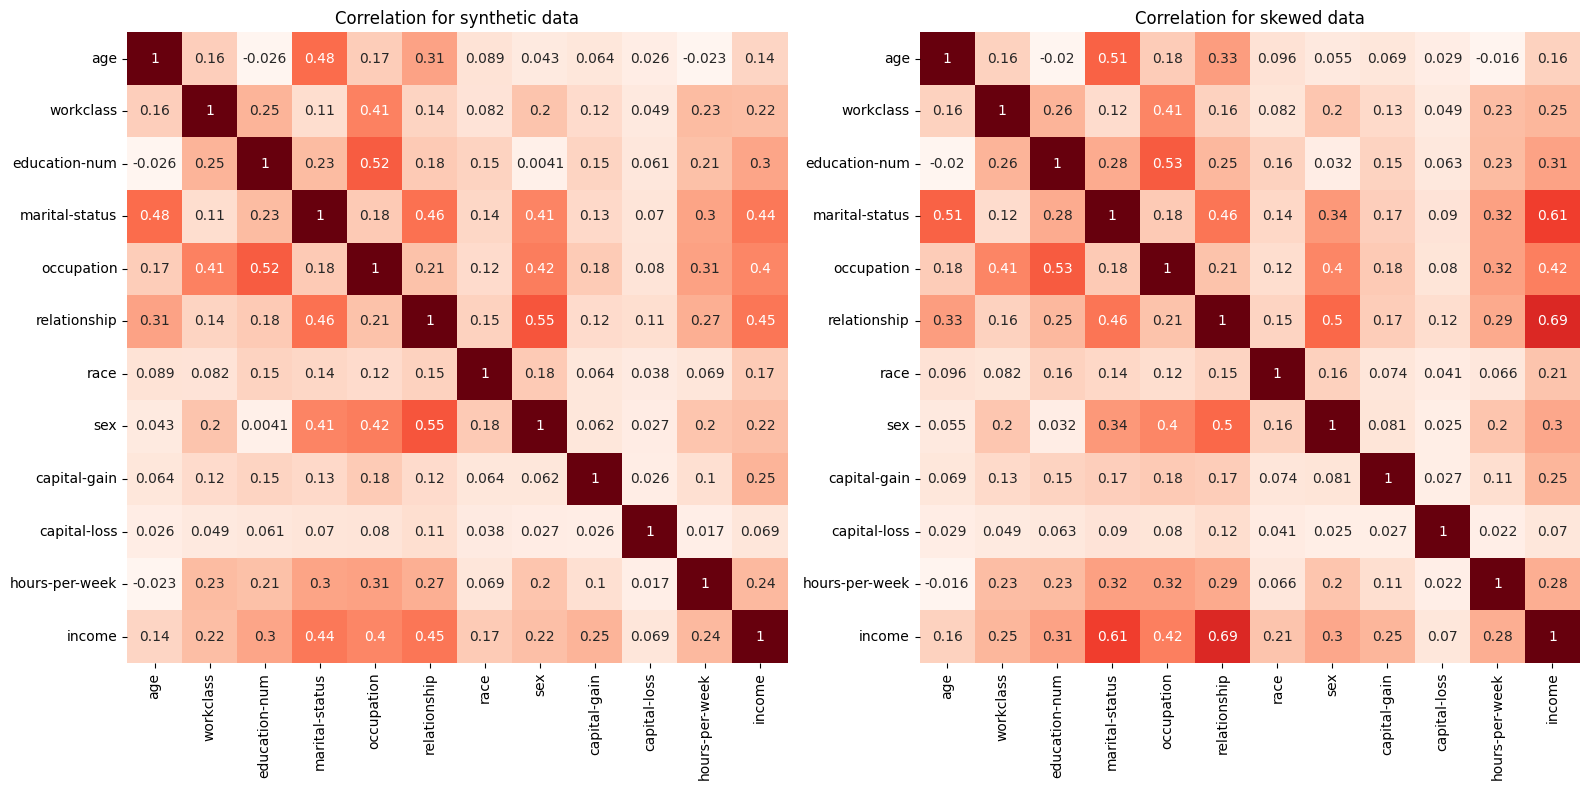

In [45]:
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate associations for two datasets
assoc1 = associations(_df_train, compute_only=True)
assoc2 = associations(df_train, compute_only=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first association matrix
sns.heatmap(assoc1['corr'], ax=ax1, cmap="Reds", annot=True, cbar=False)
ax1.set_title('Correlation for synthetic data')

# Plot the second association matrix
sns.heatmap(assoc2['corr'], ax=ax2, cmap="Reds", annot=True, cbar=False)
ax2.set_title('Correlation for skewed data')

# Display the plots
plt.tight_layout()
plt.show()


## Train baseline

In [46]:
from sklearn.linear_model import LogisticRegression
from utils import create_model, train_and_evaluate, describe_model

In [47]:
clf = LogisticRegression(max_iter=1000, random_state=random_state)

In [48]:
## Train baseline
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred, verbose=True)

Metric         Value               
Accuracy       0.7840493362600606
Precision      0.7255443955319052
Recall         0.7794318773548714
F1             0.7395361251266778


## Fairness Evaluation

In [49]:
from utils import split_data
from utils_fairness import search_bias, calc_fairness_score, explain_detected_bias

In [63]:
X_train, y_train = split_data(df_train, target, drop_na=True)

In [64]:
model = create_model(clf, nominal_features)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1]) # we select for target label

In [65]:
privileged_subset, _ = search_bias(X_train, y_train, probs, 1, penalty=1)

In [61]:
print(privileged_subset)

({'relationship': ['Husband']}, 862.931)


In [58]:
calc_fairness_score(df_train, privileged_subset[0].keys(), target, verbose=True)

Sensitive Attributes: ['relationship']

         Group Distance  Proportion  Counts   P-Value
       Husband    0.524    0.229794    7253  0.00e+00
 Not-in-family   -0.165    0.374014   11805 4.94e-324
     Own-child   -0.223    0.120014    3788 4.94e-324
     Unmarried   -0.206    0.133067    4200 3.35e-301
Other-relative   -0.217    0.044641    1409 4.28e-118
          Wife    0.052    0.098470    3108  2.49e-11

Weighted Mean Statistical Distance: 0.2512407420712662


In [55]:
explain_detected_bias(df_train, probs, target, privileged_subset[0])

Our detected privileged group has a size of 17277, we observe 0.0764 as the average probability of earning >50k, but our model predicts 0.2246


In [56]:
X_test, y_test = split_data(df_test, target, drop_na=True)
model = create_model(clf, nominal_features)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_test)[:, 1]) # we select for target label
privileged_subset, _ = search_bias(X_test, y_test, probs, 1, penalty=1)
print(privileged_subset)

({'relationship': ['Husband']}, 862.931)


## Fairness Metrics

In [19]:
from utils_fairness import transform_to_bias_dataset, describe_fairness, scan_and_calculate_fairness, plot_fairness_metrics

In [20]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

1744 Na rows removed!
202 Na rows removed!


In [21]:
model = create_model(clf, nominal_features)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_fairness(df_test_bias[target], y_pred, list(privileged_subset[0].keys()), verbose=True)

Metric                          Value               
statistical_parity_difference   0.36039973020893473
average_odds_difference         0.1727326304343043
equal_opportunity_difference    0.2344466774183982
disparate_impact                3.142593511411733
theil_index                     0.1311121502906571


In [ ]:
df_fairness_metrics, priviliged_subsets = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
), {}

for i in [1e-17, 1e-10, 0.001, 0.01, 0.1, 0, 1, 5, 10, 25, 50, 100]:
    metrics, priv = scan_and_calculate_fairness(model, df_train, target, i)    
    df_fairness_metrics.loc[f"penalty_{i}"] = metrics.values()
    priviliged_subsets[f"penalty_{i}"] = priv

In [ ]:
df_fairness_metrics

In [ ]:
df_fairness_metrics.to_json("./results/fairness_metrics_skewed.json")

In [ ]:
plot_fairness_metrics(df_fairness_metrics)

## Mitigation

In [ ]:
from tqdm import tqdm
from sklearn import clone
from aif360.algorithms.preprocessing import Reweighing
from utils_fairness import create_aif360_standardDataset, compute_metrics, reweight_mitigation
from utils import plot_metrics

### Reweighting

In [ ]:
# create (un)privileged groups
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

# convert dataset
train_dataset = create_aif360_standardDataset(df_train, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))
test_dataset = create_aif360_standardDataset(df_test, nominal_features, target, 1, list(privileged_subset[0].keys()), list(privileged_subset[0].values()))

# train model
model = clone(clf)
model.fit(train_dataset.features, train_dataset.labels.ravel())
y_pred = model.predict(train_dataset.features)

# model = create_model(clf, nominal_features)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_train)

# compare results
train_dataset_prediction = train_dataset.copy()
train_dataset_prediction.labels = y_pred.reshape(-1, 1)
train_dataset_prediction.scores = y_pred.reshape(-1, 1)
_ = compute_metrics(train_dataset, train_dataset_prediction, unprivileged_groups, privileged_groups)

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(train_dataset)

train_dataset_reweight = RW.transform(train_dataset)

In [ ]:
model = create_model(clf, nominal_features)

# original model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=None)
_ = describe_model(y_test, y_pred, verbose=True)

# mitigated model
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=train_dataset_reweight.instance_weights)
_ = describe_model(y_test, y_pred, verbose=True)

In [ ]:
def check_equal_index(standard_dataset, df_compare):
    df1, _ = standard_dataset.convert_to_dataframe()
    return df1.index.equals(df_compare.index)

In [ ]:
check_equal_index(train_dataset, df_train.dropna())

In [ ]:
df_fairness_metrics = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [weights]
max_iter = 10
for i in tqdm(range(max_iter)):
    X_train, y_train = split_data(df_train, target, True)
    X_test, y_test = split_data(df_test, target, True)
    weights, model_metrics, fair_metrics = reweight_mitigation(clf, nominal_features, target, X_train, y_train, X_test, y_test, penalty=25, sample_weights=weights)
    if model_metrics is None and fair_metrics is None and weights is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_fairness_metrics.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)

In [ ]:
plot_fairness_metrics(df_fairness_metrics)

In [ ]:
df_fairness_metrics

In [ ]:
plot_metrics(df_metrics, 'Iteration', 'Value', 'Metrics over multiple Mitigation rounds')

In [ ]:
df_metrics

### Fair Learning

In [ ]:
from utils import prepare_data_fair_learning, plot_fairlearning_results
from utils_fairness import get_fair_learning_scoring

In [ ]:
df_train_bias = transform_to_bias_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)
df_test_bias = transform_to_bias_dataset(df_test, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), verbose=True)

X_train, y_train, X_test, y_test = prepare_data_fair_learning(df_train_bias, df_test_bias, nominal_features, target)

In [ ]:
max_delta = get_fair_learning_scoring(list(privileged_subset[0].keys()))

In [ ]:
from sklearn.model_selection import GridSearchCV
from aif360.sklearn.preprocessing import LearnedFairRepresentations

lfr = LearnedFairRepresentations(list(privileged_subset[0].keys()), n_prototypes=25, max_iter=100, random_state=random_state)
params = {
    "reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    "fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(X_train, y_train, priv_group=(1,)*len(list(privileged_subset[0].keys())))
res = pd.DataFrame(grid.cv_results_)
display(res)

In [ ]:
plot_fairlearning_results(res)

In [ ]:
model = create_model(clf, [])

In [ ]:
model.fit(X_train, y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

In [ ]:
_ = describe_model(y_test, grid.predict(X_test), verbose=True)
_ = describe_fairness(y_train, grid.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)

In [ ]:
model.fit(grid.transform(X_train), y_train)

_ = describe_model(y_test, model.predict(X_test), verbose=True)
_ = describe_fairness(y_train, model.predict(X_train), list(privileged_subset[0].keys()) ,verbose=True)
_ = describe_fairness(y_train, model.predict(grid.transform(X_train)), list(privileged_subset[0].keys()) ,verbose=True)

Multiple Runs cannot be done, because of the dataset already needs to be one hot encoded for the mitigation, making the `search_bias` function unnecessary and returning not viable resolutions.

### Fair Adapt